# softmax回归

## 图像分类数据集
MNIST数据集是图像分类中广泛使用的数据集之一，但作为基准数据集过于简单。我们将使用类似但更复杂的Fashion-MNIST数据集

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

过框架中的内置函数将 Fashion-MNIST 数据集下载并读取到内存中

In [ ]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True,
                                                transform=trans,
                                                download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False,
                                               transform=trans, download=True)

len(mnist_train), len(mnist_test)

In [ ]:
mnist_train[0][0].shape

两个可视化数据集的函数

In [ ]:
ef get_fashion_mnist_labels(labels):  
    """返回Fashion-MNIST数据集的文本标签。"""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

几个样本的图像及其相应的标签

In [ ]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

读取一小批量数据，大小为batch_size

In [ ]:
batch_size = 256

def get_dataloader_workers():  
    """使用4个进程来读取数据。"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

定义 load_data_fashion_mnist 函数

In [ ]:
def load_data_fashion_mnist(batch_size, resize=None):  
    """下载Fashion-MNIST数据集，然后将其加载到内存中。"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

## softmax回归的从零开始实现
就像我们从零开始实现线性回归一样， 你应该知道实现softmax的细节

In [3]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

100.0%

Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw


111.0%

Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw


100.0%

Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw


159.1%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw
Processing...
Done!


C:\Users\22479\.conda\envs\torch\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


将展平每个图像，把它们看作长度为784的向量。 因为我们的数据集有10个类别，所以网络输出维度为 10

In [4]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

给定一个矩阵X，我们可以对所有元素求和

In [5]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

实现softmax 

In [6]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

我们将每个元素变成一个非负数。此外，依据概率原理，每行总和为1

In [7]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.3979, 0.0823, 0.0896, 0.0447, 0.3856],
         [0.2131, 0.2571, 0.0648, 0.3631, 0.1019]]),
 tensor([1.0000, 1.0000]))

实现softmax回归模型

In [8]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

创建一个数据y_hat，其中包含2个样本在3个类别的预测概率， 使用y作为y_hat中概率的索引

In [9]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

实现交叉熵损失函数

In [10]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

将预测类别与真实 y 元素进行比较

In [11]:
def accuracy(y_hat, y):  
    """计算预测正确的数量。"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

我们可以评估在任意模型 net 的准确率

In [12]:
def evaluate_accuracy(net, data_iter):  
    """计算在指定数据集上模型的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

Accumulator 实例中创建了 2 个变量，用于分别存储正确预测的数量和预测的总数量

In [13]:
class Accumulator:  
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

evaluate_accuracy(net, test_iter)

0.1248

Softmax回归的训练

In [14]:
def train_epoch_ch3(net, train_iter, loss, updater):  
    """训练模型一个迭代周期（定义见第3章）。"""
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), accuracy(y_hat, y),
                y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

定义一个在动画中绘制数据的实用程序类

In [15]:
class Animator:  
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

训练函数

In [16]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

小批量随机梯度下降来优化模型的损失函数

In [17]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

对图像进行分类预测

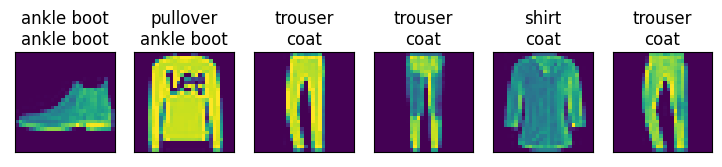

In [18]:
def predict_ch3(net, test_iter, n=6):  
    """预测标签（定义见第3章）。"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## Softmax 回归的简洁实现